<a href="https://colab.research.google.com/github/Namsik-Yoon/pytorch_basic/blob/master/12.%20%EC%8B%9C%ED%80%80%EC%8A%A4%20%EB%A0%88%EC%9D%B4%EB%B8%94%EB%A7%81%2C%20%EC%8B%9C%ED%80%80%EC%8A%A4%ED%88%AC%EC%8B%9C%ED%80%80%EC%8A%A4(%EC%8B%A4%ED%97%98%20%EC%B6%94%EA%B0%80%EC%A4%91).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12. 시퀀스 레이블링, 시퀀스2시퀀스(SeqLabeling and Seq2Seq)

## 12.1 시퀀스 레이블링(Sequence Labeling)

이번 챕터에서는 파이토치(PyTorch)로 인공 신경망을 이용하여 태깅 작업을 하는 모델을 만듭니다. 개체명 인식기와 품사 태거를 만드는데, 이러한 두 작업의 공통점은 RNN의 다-대-다(Many-to-Many) 작업이면서 또한 앞, 뒤 시점의 입력을 모두 참고하는 양방향 RNN(Bidirectional RNN)을 사용한다는 점입니다.

두 개의 실습 챕터를 진행하기 전에 전체적으로 실습이 어떻게 진행되는지 정리해보도록 하겠습니다. 텍스트 분류 개요 챕터와 겹치는 부분에 대해서는 요약하여 설명하므로, 이해가 되지 않는 부분이 있다면 해당 챕터를 참고바랍니다.

### 12.1.1 훈련 데이터에 대한 이해



태깅 작업은 앞서 배운 텍스트 분류 작업과 동일하게 지도 학습(Supervised Learning)에 속합니다. 이 챕터에서는 태깅을 해야하는 단어 데이터를 X, 레이블에 해당되는 태깅 정보 데이터는 y라고 이름을 붙였습니다. X에 대한 훈련 데이터는 X_train, 테스트 데이터는 X_test라고 명명하고 y에 대한 훈련 데이터는 y_train, 테스트 데이터는 y_test라고 명명합니다.

이번 챕터에서 X와 y데이터의 쌍(pair)은 병렬 구조를 가진다는 특징을 가집니다. X와 y의 각 샘플의 길이는 같습니다. 예를 들어 품사 태깅 작업을 한다고 가정해보겠습니다. 그리고 X_train와 y_train의 데이터 중 4개의 샘플만 확인해본다고 가정해보겠습니다. 이 때 데이터는 다음과 같은 구조를 가집니다.

|-|X_train|y_train|길이|
|---|---|---|---|
|0|['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']|['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O']|8|
|1|['peter', 'blackburn']|['B-PER', 'I-PER']|2|
|2|['brussels', '1996-08-22' ]|['B-LOC', 'O']|2|
|3|['The', 'European', 'Commission']|	['O', 'B-ORG', 'I-ORG']|3|

가령, X_train[3]의 'The'와 y_train[3]의 'O'는 하나의 쌍(pair)입니다. 또한, X_train[3]의 'European'과 y_train[3]의 'B-ORG'는 쌍의 관계를 가지며, X_train[3]의 'Commision'과 y_train[3]의 'I-ORG'는 쌍의 관계를 가집니다.

이렇게 병렬 관계를 가지는 각 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기위한 패딩(Padding) 작업을 거칩니다.

## 12.1.2 시퀀스 레이블링(Sequence Labeling)

위와 같이 입력 시퀀스 $X = [x_1, x_2, x_3, ..., x_n]$에 대하여 레이블 시퀀스 $y = [y_1, y_2, y_3, ..., y_n]$를 각각 부여하는 작업을 시퀀스 레이블링 작업(Sequence Labeling Task)이라고 합니다. 태깅 작업은 대표적인 시퀀스 레이블링 작업입니다.

### 12.1.3 양방향 RNN(Bidirectional RNN)

```
nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first=True, bidirectional = True)
```

이번 챕터에서도 바닐라 RNN이 아니라 성능이 개선된 RNN인 LSTM이나 GRU 등을 사용합니다. 텍스트 분류 챕터에서는 단방향 RNN을 사용하였지만, 이번 챕터에서는 양방향 RNN을 사용합니다. 이전 시점의 단어 정보 뿐만 아니라, 다음 시점의 단어 정보도 참고하기 위함입니다. 양방향은 기존의 단방향 nn.RNN()에서 bidirectional 인자의 값으로 True를 넣으면 됩니다.

### 12.1.4 RNN의 다-대-다(Many-to-Many) 문제

이제 RNN이 어떻게 설계되는지 확인해보도록 하겠습니다. 예를 들어 위에서 설명한 데이터 중 첫번째 데이터에 해당되는 X_train[0]를 가지고 4번의 시점(time steps)까지 RNN을 진행하였을 때의 그림은 다음과 같습니다.

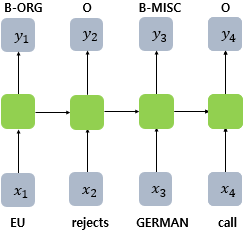


하지만 이번 실습에서는 양방향 RNN을 사용할 것이므로 아래의 그림과 같습니다.

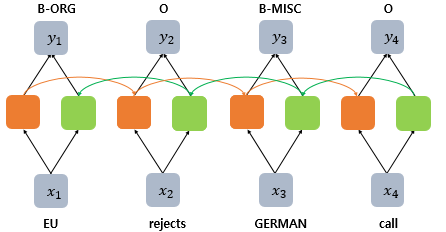

## 12.2 양방향 RNN을 이용한 품사 태깅

이번 챕터에서는 파이토치(PyTorch)를 사용하여 시퀀스 레이블링의 대표적인 태스크인 품사 태깅(PoS tagging) 작업을 구현해보겠습니다.

### 12.2.1 셋팅하기

우선 필요한 도구들을 임포트합니다.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import time
import random

SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 12.2.2 훈련 데이터에 대한 이해

이번 챕터에서도 토치 텍스트를 사용합니다.

1) 필드 정의하기

이번에 사용할 데이터응 총 3개의 열, 즉, 다시 말해 3개의 필드를 가지고 있습니다. 레이블이 총 2개이기 때문인데 이 중 1개만 사용할 것이지만 원활하게 데이터를 불러오기 위해서 일단은 3개 모두 필드를 정의해줍니다.

In [ ]:
# 3개의 필드 정의
TEXT = data.Field(lower = True)
UD_TAGS = data.Field(unk_token = None)
PTB_TAGS = data.Field(unk_token = None)

fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

2) 데이터셋 만들기

이제 토치텍스트에서 제공하는 훈련 데이터를 불러오는 동시에 데이터셋을 만들어보겠습니다. 훈련 데이터, 검증 데이터, 테스트 데이터를 각각 나눠서 저장해줍니다.

In [ ]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

훈련 데이터, 검증 데이터, 테스트 데이터의 크기를 확인해봅시다.

In [ ]:
print(f"훈련 샘플의 개수 : {len(train_data)}")
print(f"검증 샘플의 개수 : {len(valid_data)}")
print(f"테스트 샘플의 개수 : {len(test_data)}")

훈련 샘플의 개수 : 12543
검증 샘플의 개수 : 2002
테스트 샘플의 개수 : 2077


데이터셋을 생성하였으니 훈련 데이터의 필드들을 출력해봅시다.

In [ ]:
# 훈련 데이터의 3개의 필드 확인
print(train_data.fields)

{'text': <torchtext.data.field.Field object at 0x7f401211ea58>, 'udtags': <torchtext.data.field.Field object at 0x7f401211e9e8>, 'ptbtags': <torchtext.data.field.Field object at 0x7f401211ea90>}


훈련 데이터의 첫번째 샘플에서 text와 두 개의 레이블을 모두 출력해보겠습니다.

In [ ]:
# 첫번째 훈련 샘플의 text 필드
print(vars(train_data.examples[0])['text'])

['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']


첫번째 레이블은 udtags입니다. 우리가 사용할 레이블입니다.

In [ ]:
# 첫번째 훈련 샘플의 udtags 필드
print(vars(train_data.examples[0])['udtags'])

['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


두번째 레이블은 ptbdtags입니다. 여기서는 사용하지 않을 레이블입니다.

In [ ]:
# 첫번째 훈련 샘플의 ptbdtags 필드
print(vars(train_data.examples[0])['ptbtags'])

['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']


3) 단어 집합(Vocabulary) 만들기

이제 단어 집합을 생성해보겠습니다. 그리고 단어 집합을 생성 시에 사전 훈련된 워드 임베딩인 GloVe를 사용합니다.

In [ ]:
# 최소 허용 빈도
MIN_FREQ = 5

# 사전 훈련된 워드 임베딩 GloVe 다운로드
TEXT.build_vocab(train_data, min_freq = MIN_FREQ, vectors = "glove.6B.100d")
UD_TAGS.build_vocab(train_data)
PTB_TAGS.build_vocab(train_data)

상위 빈도수 20개의 단어만 출력해봅시다. .vocab.freqs.most_common(20)를 통해 출력 가능합니다.

In [ ]:
# 상위 빈도수 20개 단어
print(TEXT.vocab.freqs.most_common(20))

[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('is', 2239), ('you', 2156), ('that', 2036), ('it', 1850), ('for', 1842), ('-', 1426), ('have', 1359), ('"', 1296), ('on', 1273), ('was', 1244), ('with', 1216)]


영어에서는 (다른 여러 훈련 데이터에서도) 보통 the가 빈도수가 가장 많습니다. 토치텍스트는 기본적으로 빈도수가 가장 높은 단어부터 작은 숫자를 부여합니다. 물론, <unk>는 0번, <pad>는 1번으로 자동으로 부여되므로 제외입니다.

상위 정수 인덱스를 가진 10개의 단어를 출력합니다. 다시 말해 0번부터 9번까지의 단어를 출력해보겠습니다.

In [ ]:
# 상위 정수 인덱스 단어 10개 출력
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', '.', ',', 'to', 'and', 'a', 'of', 'i']


이제 레이블의 단어 집합에 대해서 빈도수가 가장 높은 단어들과 그 빈도수를 출력해보겠습니다.

In [ ]:
# 상위 빈도순으로 udtags 출력
print(UD_TAGS.vocab.freqs.most_common())

[('NOUN', 34781), ('PUNCT', 23679), ('VERB', 23081), ('PRON', 18577), ('ADP', 17638), ('DET', 16285), ('PROPN', 12946), ('ADJ', 12477), ('AUX', 12343), ('ADV', 10548), ('CCONJ', 6707), ('PART', 5567), ('NUM', 3999), ('SCONJ', 3843), ('X', 847), ('INTJ', 688), ('SYM', 599)]


상위 정수 인덱스를 가진 10개의 단어를 출력합니다. 다시 말해 0번부터 9번까지의 단어를 출력해보겠습니다.

In [ ]:
# 상위 정수 인덱스 순으로 출력
print(UD_TAGS.vocab.itos)

['<pad>', 'NOUN', 'PUNCT', 'VERB', 'PRON', 'ADP', 'DET', 'PROPN', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PART', 'NUM', 'SCONJ', 'X', 'INTJ', 'SYM']


레이블에 속한 단어들의 분포를 출력해보겠습니다.

In [ ]:
def tag_percentage(tag_counts): # 태그 레이블의 분포를 확인하는 함수
    total_count = sum([count for tag, count in tag_counts])
    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]
    return tag_counts_percentages


print("Tag  Occurences Percentage\n")
for tag, count, percent in tag_percentage(UD_TAGS.vocab.freqs.most_common()):
    print(f"{tag}\t{count}\t{percent*100:4.1f}%")

Tag  Occurences Percentage

NOUN	34781	17.0%
PUNCT	23679	11.6%
VERB	23081	11.3%
PRON	18577	 9.1%
ADP	17638	 8.6%
DET	16285	 8.0%
PROPN	12946	 6.3%
ADJ	12477	 6.1%
AUX	12343	 6.0%
ADV	10548	 5.2%
CCONJ	6707	 3.3%
PART	5567	 2.7%
NUM	3999	 2.0%
SCONJ	3843	 1.9%
X	847	 0.4%
INTJ	688	 0.3%
SYM	599	 0.3%


4) 데이터로더 만들기

이제 데이터로더를 만듭니다. 배치 크기는 64로 합니다.

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

첫번째 미니 배치만 꺼내서 미니 배치의 구성, 크기, text를 출력해봅시다.

In [ ]:
batch = next(iter(train_iterator))
batch


[torchtext.data.batch.Batch of size 64 from UDPOS]
	[.text]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]
	[.udtags]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]
	[.ptbtags]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]

첫번째 미니 배치의 text의 크기를 출력해봅시다.

In [ ]:
batch.text.shape

torch.Size([46, 64])

첫번째 미니 배치의 크기는 (시퀀스 길이 × 배치 크기)입니다. batch_first=True를 하지 않았으므로 배치 크기가 두번째 차원이 됩니다.

In [ ]:
batch.text

tensor([[ 732,  167,    2,  ...,    2,   59,  668],
        [  16,  196,  133,  ..., 2991,   46,    1],
        [   1,   29,   48,  ..., 1582,   12,    1],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

### 12.2.3 모델 구현하기

이제 모델을 구현해봅시다. 기본적으로 다대다 RNN을 사용할텐데, 일단 양방향 여부와 층의 개수는 변수로 두겠습니다.

In [ ]:
# 이번 모델에서는 batch_first=True를 사용하지 않으므로 배치 차원이 맨 앞이 아님.
class RNNPOSTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout): 
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))

        # embedded = [sent len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)

        # output = [sent len, batch size, hid dim * n directions]
        # hidden/cell = [n layers * n directions, batch size, hid dim]
        predictions = self.fc(self.dropout(outputs))

        # predictions = [sent len, batch size, output dim]
        return predictions

실제 클래스로부터 모델 객체로 생성 시에 양방향 여부를 True로 주고, 층의 개수를 2로 합니다.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = RNNPOSTagger(INPUT_DIM, 
                     EMBEDDING_DIM, 
                     HIDDEN_DIM, 
                     OUTPUT_DIM, 
                     N_LAYERS, 
                     BIDIRECTIONAL, 
                     DROPOUT)

파라미터 개수를 출력해보겠습니다.

In [ ]:
# 파라미터 개수 출력
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,027,510 trainable parameters


총 102만 7천 5백 10개의 파라미터가 있습니다.

### 12.2.4 사전 훈련된 워드 임베딩 사용하기

앞서 언급하였던대로, 이번 챕터에서는 사전 훈련된 워드 임베딩인 GloVe를 사용합니다. 이를 위해서는 토치텍스트의 단어 집합 생성 시에 저장해두었던 GloVe 임베딩을 nn.Embedding()에 연결해줄 필요가 있습니다. 우선 단어 집합의 단어들에 맵핑된 사전 훈련된 워드 임베딩을 출력합니다.

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([3921, 100])


단어 집합에 존재하는 총 3,921개의 단어에 대해서 100차원의 벡터가 맵핑되어져 있습니다. 이제 nn.Embedding()에 이를 연결시켜줍니다.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings) # 임베딩 벡터값 copy

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1020,  0.7700,  0.1169,  ..., -0.1416, -0.1932, -0.4225],
        [-0.0263,  0.0179, -0.5016,  ..., -0.8688,  0.9409, -0.2882],
        [ 0.1519,  0.4712,  0.0895,  ..., -0.4702, -0.3127,  0.1078]])

우선 $<unk>$ 토큰의 인덱스와 $<pad>$ 토큰의 인덱스를 저장해둡니다. (물론, 각각 0과 1임을 이미 우리는 알고 있습니다.)

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
print(UNK_IDX)
print(PAD_IDX)

0
1


그리고 임의로 0번과 1번 단어에는 0벡터를 만들어줍니다.

In [ ]:
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # 0번 임베딩 벡터에는 0값을 채운다.
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # 1번 임베딩 벡터에는 1값을 채운다.
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1020,  0.7700,  0.1169,  ..., -0.1416, -0.1932, -0.4225],
        [-0.0263,  0.0179, -0.5016,  ..., -0.8688,  0.9409, -0.2882],
        [ 0.1519,  0.4712,  0.0895,  ..., -0.4702, -0.3127,  0.1078]])


PAD 토큰과 UNK 토큰의 임베딩 벡터값이 0인것을 볼 수 있습니다. 사전 훈련된 워드 임베딩을 사용할 준비가 되었습니다.

### 12.2.5 옵티마이저와 비용 함수 구현하기

옵티마이저 설계 전에 레이블 데이터의 패딩 토큰의 인덱스도 확인해봅시다.

In [ ]:
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]
print(TAG_PAD_IDX)

0


0인 것을 확인할 수 있습니다. 이를 하는 이유는 아래 비용 함수를 선택할 때 인자로 주기 위함입니다. 이제 옵티마이저를 설정합니다. 여기서는 Adam을 택했습니다.

In [ ]:
optimizer = optim.Adam(model.parameters())

비용 함수로 크로스엔트로피 함수를 선택합니다. 이때 레이블 데이터의 패딩 토큰은 비용 함수의 연산에 포함시키지도 않도록 레이블 데이터의 패딩 토큰을 무시하라고 기재해줍니다.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

현재 GPU를 사용 중일때 GPU 연산을 할 수 있도록 지정해줍니다.

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

아직 모델은 훈련되지 않은 상태이지만 모델에 입력값을 넣어 출력(예측값)의 크기를 확인해볼까요? 여기서 넣는 입력값은 앞에서 꺼내두었던 첫번째 배치입니다.

In [ ]:
prediction = model(batch.text)

예측값의 크기는 다음과 같습니다.

In [ ]:
prediction.shape

torch.Size([46, 64, 18])

46 × 64 × 18은 각각 (첫번째 배치의 시퀀스 길이 × 배치 크기 × 레이블 단어장의 크기)에 해당됩니다. 주의할 점은 현재는 batch_first를 해주지 않아 배치 크기가 맨 앞 차원이 아니라는 점입니다. 또한 46은 첫번째 배치의 시퀀스 길이일뿐, 다른 배치들은 시퀀스 길이가 다를 수 있습니다.

이제 예측값에 대해서 시퀀스 길이와 배치 길이를 모두 펼쳐주는 작업을 해보겠습니다.

In [ ]:
prediction = prediction.view(-1, prediction.shape[-1])
prediction.shape

torch.Size([2944, 18])

크기가 (2,944 × 18)이 됩니다. 이번에는 첫번째 배치의 레이블 데이터의 크기를 보겠습니다.

In [ ]:
batch.udtags.shape

torch.Size([46, 64])

46 × 64는 (첫번째 배치의 시퀀스 길이 × 배치 크기)에 해당됩니다. 이를 펼쳐보겠습니다.

In [ ]:
batch.udtags.view(-1).shape

torch.Size([2944])

2,944의 크기를 가지게 됩니다.

## 12.3 시퀀스투시퀀스(Sequence-to-Sequence, seq2seq)

시퀀스-투-시퀀스(Sequence-to-Sequence)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델입니다. 예를 들어 챗봇(Chatbot)과 기계 번역(Machine Translation)이 그러한 대표적인 예인데, 입력 시퀀스와 출력 시퀀스를 각각 질문과 대답으로 구성하면 챗봇으로 만들 수 있고, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기로 만들 수 있습니다. 그 외에도 내용 요약(Text Summarization), STT(Speech to Text) 등에서 쓰일 수 있습니다.

이번 챕터에서는 기계 번역을 예제로 시퀀스-투-시퀀스를 설명합니다. 앞으로는 줄여서 seq2seq이라는 이름으로 설명하겠습니다. seq2seq에 대한 구조를 이해하고, 파이토치(PyTorch)를 통해 직접 구현해봅시다.

### 12.3.1 모델의 개요(Overview)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다. 앞으로의 설명 방식은 내부가 보이지 않는 커다란 블랙 박스에서 점차적으로 확대해가는 방식으로 설명합니다. 참고로 여기서 설명하는 내용의 대부분은 RNN 챕터에서 언급한 내용들입니다. 단지 이것을 가지고 어떻게 조립했느냐에 따라서 seq2seq라는 구조가 만들어집니다.

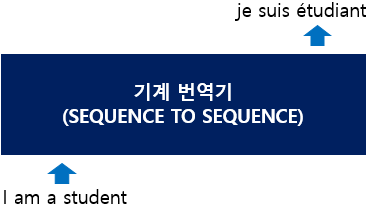

위의 그림은 seq2seq 모델로 만들어진 번역기가 'I am a student'라는 영어 문장을 입력받아서, 'je suis étudiant'라는 프랑스 문장을 출력하는 모습을 보여줍니다. 그렇다면, seq2seq 모델 내부의 모습은 어떻게 구성되었을까요?

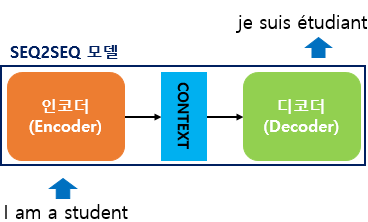


seq2seq는 크게 두 개로 구성된 아키텍처로 구성되는데, 바로 인코더와 디코더입니다. 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 컨텍스트 벡터(context vector)라고 합니다. 컨텍스트란 한국어로는 '문맥'입니다. 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송합니다. 디코더는 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력합니다.

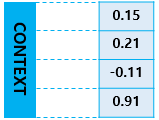

위의 그림에서는 컨텍스트 벡터를 4의 사이즈로 표현하였지만, 실제 현업에서 사용되는 seq2seq 모델에서는 보통 수백 이상의 차원을 갖고있습니다. 이제 인코더와 디코더의 내부를 좀 더 확대해보겠습니다.

### 12.3.2 seq2seq의 동작 과정

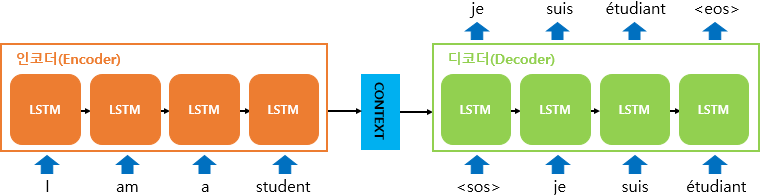

인코더 아키텍처와 디코더 아키텍처의 내부는 사실 두 개의 RNN 아키텍처 입니다. 입력 문장을 받는 RNN 셀을 인코더라고 하고, 출력 문장을 출력하는 RNN 셀을 디코더라고 합니다. 이번 챕터에서는 인코더의 RNN 셀을 주황색으로, 디코더의 RNN 셀을 초록색으로 표현합니다. 물론, 성능 문제로 인해 실제로는 바닐라 RNN이 아니라 LSTM 셀 또는 GRU 셀들로 구성됩니다. 우선 인코더를 자세히보면, 입력 문장은 단어 토큰화를 통해서 단어 단위로 쪼개지고 단어 토큰 각각은 RNN 셀의 각 시점의 입력이 됩니다. 인코더 RNN 셀은 모든 단어를 입력받은 뒤에 인코더 RNN 셀의 마지막 시점의 은닉 상태를 디코더 RNN 셀로 넘겨주는데 이를 컨텍스트 벡터라고 합니다. 컨텍스트 벡터는 디코더 RNN 셀의 첫번째 은닉 상태로 사용됩니다.

1) 테스트 단계

디코더는 초기 입력으로 문장의 시작을 의미하는 심볼 $<sos>$가 들어갑니다. 디코더는 $<sos>$가 입력되면, 다음에 등장할 확률이 높은 단어를 예측합니다. 첫번째 시점(time step)의 디코더 RNN 셀은 다음에 등장할 단어로 je를 예측하였습니다. 첫번째 시점의 디코더 RNN 셀은 예측된 단어 je를 다음 시점의 RNN 셀의 입력으로 입력합니다. 그리고 두번째 시점의 디코더 RNN 셀은 입력된 단어 je로부터 다시 다음에 올 단어인 suis를 예측하고, 또 다시 이것을 다음 시점의 RNN 셀의 입력으로 보냅니다. 디코더는 이런 식으로 기본적으로 다음에 올 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다. 이 행위는 문장의 끝을 의미하는 심볼인 $<eos>$가 다음 단어로 예측될 때까지 반복됩니다. 지금 설명하는 것은 테스트 과정 동안의 이야기입니다.

2) 훈련 단계와 교사 강요

seq2seq는 훈련 과정과 테스트 과정(또는 실제 번역기를 사람이 쓸 때)의 작동 방식이 조금 다릅니다. 훈련 과정에서는 디코더에게 인코더가 보낸 컨텍스트 벡터와 실제 정답인 상황인 <sos> je suis étudiant를 입력 받았을 때, je suis étudiant <eos>가 나와야 된다고 정답을 알려주면서 훈련합니다. 이를 교사 강요(teacher forcing)라고 합니다. 반면 테스트 과정에서는 앞서 설명한 과정과 같이 디코더는 오직 컨텍스트 벡터와 <go>만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다.

3) 임베딩 층(Embedding layer) - 이미 배운 내용

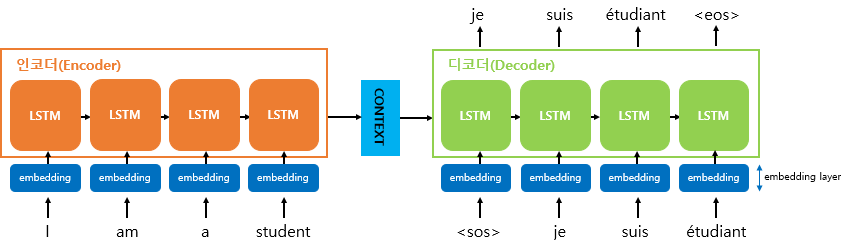

기계는 텍스트보다 숫자를 잘 처리합니다. 그리고 자연어 처리에서 텍스트를 벡터로 바꾸는 방법으로 워드 임베딩(9챕터 참고)이 사용된다고 설명한 바 있습니다. 즉, seq2seq에서 사용되는 모든 단어들은 워드 임베딩을 통해 임베딩 벡터로서 표현된 임베딩 벡터입니다. 위 그림은 모든 단어에 대해서 임베딩 과정을 거치게 하는 단계인 임베딩 층(embedding layer)의 모습을 보여줍니다.

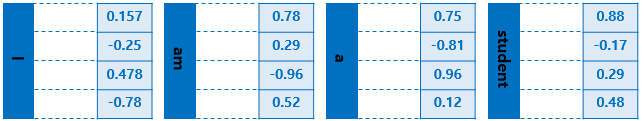

예를 들어 I, am, a, student라는 단어들에 대한 임베딩 벡터는 위와 같은 모습을 가집니다. 여기서는 그림으로 표현하고자 사이즈를 4로 하였지만, 보통 실제 임베딩 벡터는 수백 개의 차원을 가질 수 있습니다. 이제 RNN 셀에 대해서 확대해보겠습니다.

4) RNN 셀 - 이미 배운 내용

이미 RNN에 대해서 배운 적이 있지만, 다시 복습을 해보겠습니다. 하나의 RNN 셀은 각 시점(time step)마다 두 개의 입력을 받습니다.

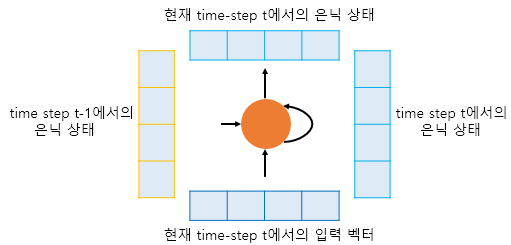

현재 시점(time step)을 t라고 할 때, RNN 셀은 t-1에서의 은닉 상태와 t에서의 입력 벡터를 입력으로 받고, t에서의 은닉 상태를 만듭니다. 이때 t에서의 은닉 상태는 바로 위에 또 다른 은닉층이나 출력층이 존재할 경우에는 위의 층으로 보내거나, 필요없으면 값을 무시할 수 있습니다. 그리고 RNN 셀은 다음 시점에 해당하는 t+1의 RNN 셀의 입력으로 현재 t에서의 은닉 상태를 입력으로 보냅니다.

RNN 챕터에서도 언급했지만, 이런 구조에서 현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의 모든 은닉 상태의 값들의 영향을 누적해서 받아온 값이라고 할 수 있습니다. 그렇기 때문에 앞서 우리가 언급했던 컨텍스트 벡터는 사실 인코더에서의 마지막 RNN 셀의 은닉 상태값을 말하는 것이며, 이는 입력 문장의 모든 단어 토큰들의 정보를 요약해서 담고있다고 할 수 있습니다.

5) 디코더

디코더는 인코더의 마지막 RNN 셀의 은닉 상태인 컨텍스트 벡터를 첫번째 은닉 상태의 값으로 사용합니다. 디코더의 첫번째 RNN 셀은 이 첫번째 은닉 상태의 값과, 현재 t에서의 입력값인 $<sos>$로부터, 다음에 등장할 단어를 예측합니다. 그리고 이 예측된 단어는 다음 시점인 t+1 RNN에서의 입력값이 되고, 이 t+1에서의 RNN 또한 이 입력값과 t에서의 은닉 상태로부터 t+1에서의 출력 벡터. 즉, 또 다시 다음에 등장할 단어를 예측하게 될 것입니다. 이제 디코더가 다음에 등장할 단어를 예측하는 부분을 확대해보도록 하겠습니다.

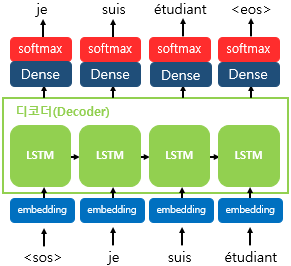

출력 단어로 나올 수 있는 단어들은 다양한 단어들이 있습니다. seq2seq 모델은 선택될 수 있는 모든 단어들로부터 하나의 단어를 골라서 예측해야 합니다. 이를 예측하기 위해서 쓸 수 있는 함수로는 뭐가 있을까요? 바로 소프트맥스 함수입니다. 디코더에서 각 시점(time step)의 RNN 셀에서 출력 벡터가 나오면, 해당 벡터는 소프트맥스 함수를 통해 출력 시퀀스의 각 단어별 확률값을 반환하고, 디코더는 출력 단어를 결정합니다.

### 12.3.3 다양한 변형들

가장 기본적인 seq2seq에 대해서 배워보았습니다. 사실 seq2seq는 어떻게 구현하느냐에 따라서 충분히 더 복잡해질 수 있습니다. 컨텍스트 벡터를 디코더의 초기 은닉 상태로만 사용할 수도 있고, 거기서 더 나아가 컨텍스트 벡터를 디코더가 단어를 예측하는 매 시점마다 하나의 입력으로 사용할 수도 있으며 거기서 더 나아가면 어텐션 메커니즘이라는 방법을 통해 지금 알고있는 컨텍스트 벡터보다 더욱 문맥을 반영할 수 있는 컨텍스트 벡터를 구하여 매 시점마다 하나의 입력으로 사용할 수도 있습니다. 어텐션 메커니즘에 대해서는 다음 챕터에서 배웁니다.

## 12.4 seq2seq 구현하기(간단한 챗봇 만들기)


seq2seq에서의 임베딩이 이전 예제와 다른 점은 패딩, 시작, 끝 등 태그를 사용한다는것입니다. 임베딩의 0~3번째에 각각 $<pad>$, $<sos>$,$<eos>$,$<unk>$ 태그를 넣습니다. 사실 그냥 똑같은 단어라고 보시면 됩니다. 다만 이단어들이 seq2seq의 동작을 제어합니다.

예를들어, 디코더의 입력에 $<sos>$가 들어가면 디코딩의 시작을 의미합니다. 반대로 디코더 출력에 $<eos>$가 나오면 디코딩을 종료합니다.

먼저 챗봇모델의 학습을 위한 데이터를 불러옵니다. 
챗봇의 훈련을 위해서 송영숙님이 공개한 한글 데이터셋을 로드합니다. 질문과 대답, 감정 등 총 3개의 항목으로 구성되어 있습니다. 감정 분류는 Seq2Seq에 필요가 없기 때문에 사용하지 않습니다.

### 12.4.1 데이터 로드

In [1]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [41.5 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ge

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

from konlpy.tag import Okt

!wget https://www.dropbox.com/s/k7jzllp6v8nv6wn/ChatbotData.csv

--2020-12-24 09:48:52--  https://www.dropbox.com/s/k7jzllp6v8nv6wn/ChatbotData.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k7jzllp6v8nv6wn/ChatbotData.csv [following]
--2020-12-24 09:48:52--  https://www.dropbox.com/s/raw/k7jzllp6v8nv6wn/ChatbotData.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc490823da0ccf1cc50437f795fa.dl.dropboxusercontent.com/cd/0/inline/BFoVwxg6xf0RXtUHhageP5vptGGEo8Yv2VS8Ni-5AnAdJxGvPlFOt4zpR2L-7ZniTAY0YBGYJVgCAOjuldTLJwt036LnK4an38DoTtkId3Nx5NuauGOlsv9P97H_b9Ywg7w/file# [following]
--2020-12-24 09:48:53--  https://uc490823da0ccf1cc50437f795fa.dl.dropboxusercontent.com/cd/0/inline/BFoVwxg6xf0RXtUHhageP5vptGGEo8Yv2VS8Ni-5AnAdJxGvPlFOt4zpR2L-7ZniTAY0YBGYJVgCAOjuldTLJwt036LnK4an38DoTt

In [4]:
# 태그 단어
PAD = "<pad>"   # 패딩
STA = "<sos>"     # 시작
END = "<eos>"       # 끝
UNK = "<unk>"       # 없는 단어(unknown)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 임베딩 벡터 차원
embedding_dim = 100

# LSTM 히든레이어 차원
lstm_hidden_dim = 128

# 정규 표현식 필터
RE_FILTER = re.compile("[.,!?\"':;~()]")

# 챗봇 데이터 로드
chatbot_data = pd.read_csv('/content/ChatbotData.csv', encoding='utf-8')
question, answer = list(chatbot_data['Q']), list(chatbot_data['A'])

In [5]:
# 데이터 개수
len(question)

11823

In [6]:
# 챗봇 데이터 출력
for i in range(10):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



### 12.4.2 단어 사전 생성

문장을 먼저 최소 단위인 토큰으로 나누어야 합니다. 한글 문장이라면 보통 KoNLPy를 통해 형태소분석을 적용합니다. Hannanum, Kkma, Komoran, Mecab, Okt(Twitter) 등 여러가지 라이브러리를 동일한 인터페이스로 실행이 가능합니다.

KoNLPy는 자바로 구현이 되어 있습니다. 맥OS와 달리 윈도우 아나콘다는 아래와 같은 작업을 거쳐야 합니다.

< 1. 자바 설치 >
커맨드창에서 'java -version' 명령어를 실행하여 버전이 1.7 이상이어야 합니다.

< 2. JPype1 설치 >
파이썬에서 자바를 호출할 수 있는 라이브러리입니다.

< 3. KoNLPy 설치 >
위의 두 가지가 미리 완료되어 있어야만 가능합니다.

아래 링크에서 좀 더 자세한 방법을 확인하시기 바랍니다.
-> https://ericnjennifer.github.io/python_visualization/2018/01/21/PythonVisualization_Chapt1.html

In [7]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Okt()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 모든 문장 반복
    for sentence in sentences:
        # 특수기호 제거
        sentence = re.sub(RE_FILTER, "", sentence)
        
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(tagger.morphs(sentence))
        sentences_pos.append(sentence)
        
    return sentences_pos

In [8]:
# 형태소분석 수행
question = pos_tag(question)
answer = pos_tag(answer)

# 형태소분석으로 변환된 챗봇 데이터 출력
for i in range(10):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()

Q : 12시 땡
A : 하루 가 또 가네요

Q : 1 지망 학교 떨어졌어
A : 위로 해 드립니다

Q : 3 박 4일 놀러 가고 싶다
A : 여행 은 언제나 좋죠

Q : 3 박 4일 정도 놀러 가고 싶다
A : 여행 은 언제나 좋죠

Q : PPL 심하네
A : 눈살 이 찌푸려지죠

Q : SD 카드 망가졌어
A : 다시 새로 사는 게 마음 편해요

Q : SD 카드 안 돼
A : 다시 새로 사는 게 마음 편해요

Q : SNS 맞팔 왜 안 하지 ㅠㅠ
A : 잘 모르고 있을 수도 있어요

Q : SNS 시간 낭비 인 거 아는데 매일 하는 중
A : 시간 을 정 하고 해보세요

Q : SNS 시간 낭비 인데 자꾸 보게 됨
A : 시간 을 정 하고 해보세요



이제 질문과 대답 문장들을 합쳐서 전체 단어 사전을 만듭니다. 자연어처리에서는 항상 이렇게 단어를 인덱스에 따라 정리를 해야합니다. 그래야지 문장을 인덱스 배열로 바꿔서 임베딩 레이어에 넣을 수 있습니다. 또한 모델의 출력에서 나온 인덱스를 다시 단어로 변환하는데도 필요합니다.

In [9]:
# 질문과 대답 문장들을 하나로 합침
sentences = []
sentences.extend(question)
sentences.extend(answer)

words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, STA, END, UNK]

In [10]:
# 단어 개수
len(words)

12656

In [11]:
# 단어 출력
words[:20]

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '헤어짐이',
 '드릴게요',
 '봐야겠다',
 '죽진',
 '놓고',
 '운명',
 '가르쳐',
 '없게',
 '길다',
 '100일',
 '똑똑해',
 '원망하게',
 '솔직했을',
 '학교폭력',
 '아저씨',
 '헤아리지']

In [116]:
# 단어와 인덱스의 딕셔너리 생성
vocab_size = 10000
word_to_index = {word: index for index, word in enumerate(words) if index <= vocab_size}
index_to_word = {index: word for index, word in enumerate(words) if index <= vocab_size}

In [117]:
# 단어 -> 인덱스
# 문장을 인덱스로 변환하여 모델 입력으로 사용
dict(list(word_to_index.items())[:20])

{'100일': 13,
 '<eos>': 2,
 '<pad>': 0,
 '<sos>': 1,
 '<unk>': 3,
 '가르쳐': 10,
 '길다': 12,
 '놓고': 8,
 '드릴게요': 5,
 '똑똑해': 14,
 '봐야겠다': 6,
 '솔직했을': 16,
 '아저씨': 18,
 '없게': 11,
 '운명': 9,
 '원망하게': 15,
 '죽진': 7,
 '학교폭력': 17,
 '헤아리지': 19,
 '헤어짐이': 4}

In [118]:
# 인덱스 -> 단어
# 모델의 예측 결과인 인덱스를 문장으로 변환시 사용
dict(list(index_to_word.items())[:20])

{0: '<pad>',
 1: '<sos>',
 2: '<eos>',
 3: '<unk>',
 4: '헤어짐이',
 5: '드릴게요',
 6: '봐야겠다',
 7: '죽진',
 8: '놓고',
 9: '운명',
 10: '가르쳐',
 11: '없게',
 12: '길다',
 13: '100일',
 14: '똑똑해',
 15: '원망하게',
 16: '솔직했을',
 17: '학교폭력',
 18: '아저씨',
 19: '헤아리지'}

### 12.4.3 전처리

Seq2Seq에서는 학습시 다음과 같이 총 3개의 데이터가 필요합니다.

인코더 입력 : 12시 땡
디코더 입력 : sos 하루 가 또 가네요
디코더 출력 : 하루 가 또 가네요 eos

원래 Seq2Seq는 디코더의 현재 출력이 디코더의 다음 입력으로 들어갑니다. 다만 학습에서는 굳이 이렇게 하지 않고 디코더 입력과 디코더 출력의 데이터를 각각 만듭니다.

그러나 예측시에는 이런 방식이 불가능합니다. 출력값을 미리 알지 못하기 때문에, 디코더 입력을 사전에 생성할 수가 없습니다. 이런 문제를 해결하기 위해 훈련 모델과 예측 모델을 따로 구성해야 합니다. 모델 생성 부분에서 다시 자세히 설명을 드리겠습니다.

In [119]:
# 문장을 인덱스로 변환
def convert_text_to_index(sentences, vocabulary): 
    sentences_index = []
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []
        sentence_index.extend([vocabulary[STA]])
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[UNK]])
        if len(sentence_index) >= max_sequences:
            sentence_index = sentence_index[:max_sequences-1] + [vocabulary[END]]
        else:
            sentence_index += [vocabulary[END]]
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return sentences_index

In [120]:
# 인코더 입력 인덱스 변환
enc_list = convert_text_to_index(question, word_to_index)

# 첫 번째 인코더 입력 출력 (12시 땡)
print(enc_list[0])
for idx in enc_list[0]:
    print(index_to_word[idx],end=' ')

[1, 8990, 3433, 2]
<sos> 12시 땡 <eos> 

In [121]:
# 디코더 입력 인덱스 변환
dec_list = convert_text_to_index(answer, word_to_index)

# 첫 번째 디코더 입력 출력 (START 하루 가 또 가네요)
print(dec_list[0])
for idx in dec_list[0]:
    print(index_to_word[idx],end=' ')

[1, 7724, 3, 2002, 5245, 2]
<sos> 하루 <unk> 또 가네요 <eos> 

In [144]:
MAX_LENGTH=30
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, enc_list, dec_list, max_length=MAX_LENGTH):
        self.enc_list = enc_list
        self.dec_list = dec_list
    def __len__(self):
        assert len(self.enc_list) == len(self.dec_list)
        return len(self.enc_list)
    def __getitem__(self, idx):
        return self.enc_list[idx][1:MAX_LENGTH], self.dec_list[idx][1:MAX_LENGTH]

In [145]:
DataSet = TextDataset(enc_list, dec_list)
DataSet[0]

([8990, 3433, 2], [7724, 3, 2002, 5245, 2])

In [146]:
def collate_fn(inputs):
    enc_input = [torch.tensor(x[0][1:]) for x in inputs]
    dec_input = [torch.tensor(x[1]) for x in inputs]
    enc_input = torch.nn.utils.rnn.pad_sequence(enc_input, padding_value=0)
    dec_input = torch.nn.utils.rnn.pad_sequence(dec_input, padding_value=0)


    lengths = torch.tensor([sum(x!=0) for x in torch.transpose(enc_input,1,0)])
    mask = dec_input!=0
    max_target_length = dec_input.size(0)
    batch = [enc_input, dec_input, lengths, mask, max_target_length]
    return batch

In [147]:
train_ratio = 0.7
train_len = int(len(DataSet)*train_ratio)
val_len = len(DataSet)-train_len

batch_size=4

train_set,val_set = torch.utils.data.random_split(DataSet,[train_len, val_len])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,collate_fn=collate_fn)

In [148]:
next(iter(train_loader))

[tensor([[   3,    3, 8993,  915],
         [   3,    3, 9009,    3],
         [   3,  836,    2, 6371],
         [1738, 3579,    0,    2],
         [   2,    3,    0,    0],
         [   0, 5661,    0,    0],
         [   0,    2,    0,    0]]), tensor([[   3, 8772, 7902, 7058],
         [1981,    3,    3, 3566],
         [ 398,    3,    2, 8325],
         [3579,  836,    0, 3579],
         [8224, 3579,    0, 2318],
         [2318,    3,    0, 8959],
         [   3,    2,    0,    2],
         [   2,    0,    0,    0]]), tensor([5, 7, 3, 4]), tensor([[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True, False,  True],
         [ True,  True, False,  True],
         [ True,  True, False,  True],
         [ True,  True, False,  True],
         [ True, False, False, False]]), 8]

In [149]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [150]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [151]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [152]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()